# Introduction to Spiking Neural Networks

## Who are we?



## Why SNNs?


## Neuromorphic devices


## What will you learn in this workshop?

### Morning session
We will do hands-on sessions on building and training models for vision tasks using data from event-based cameras. We will focus on large scale SNNs and train them using weight transfer strategy. We will then deploy your models on Speck development kits developed by SynSense.

You will also have an opportunity to play with some pre-built demo modles running on our dev-kits.

### Lunch break

### Afternoon session
We will learn about a different spiking neuron model: Leaky Integrate and Fire neuron model.
We will do hands on sessions on building and training models with BPTT for low-dimensional signal processing tasks. You will then see these models being deployed on Xylo development kits developed by SynSense. Finally we will run through the model building and training exercise for an audio task: Keyword spotting, followed by a live demonstration.

## Process continuous data *streams*

In online applications or IoT, we often need to work with data streams from various sensors. Typically, this means a batch size of one and the data spans over time. Think of video data, where the data comprises several contiguous frames, or audio where the data comprises a waveform over time.

To put it simply, we are working with data that comprises a time axis.

In [1]:
%%capture
!pip install matplotlib torch

In [2]:
# Imports
import torch
import matplotlib.pyplot as plt
plt.rcParams["image.cmap"] = 'Greys'

# Utility function
def setFig():
    plt.figure(figsize=(15, 4))
    plt.xlabel("Time")
    plt.ylabel("Data");

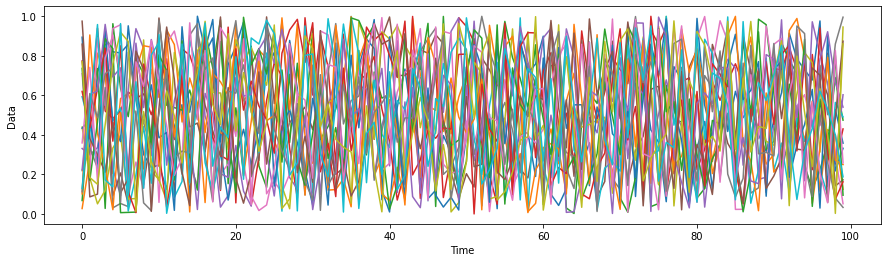

In [3]:
# Lets create and visualize such data
n_input_channels = 20
n_time_samples = 100

# Our sample data stream (time, channel)
data_stream = torch.rand((n_time_samples, n_input_channels))

# Display data
setFig()
plt.plot(data_stream);

## Artificial Neural Networks

Lets do a quick recap of ANNs.

The standard artificial neuron model used most commonly in ANNs and DNNs is a simple equation

$\vec{y} = \Theta(W.\vec{x} + b)$

where $\Theta$ is typically a non linear activation function such as a *ReLU*, *sigmoid* or *hyperbolic tangent* function.



<div>
    <img src="AN-neuron.png" width=30%/>
</div>


In [4]:
# Define a function to compute the weighted sum of an input data stream
#   Arguments:
#     x - vector of inputs (Nbatches, Nsamples, Nin,)
#     W - weight matrix (Nin, Nout)
#     b - Bias input vector (Nout,)
def forward_ann(x, W, b):
    # - Compute x matmul W
    #   Add bias vector
    return x @ W + b


In [5]:
# Let us generate a random weight matrix
W = torch.rand((n_input_channels, 1))
b =  -0.2  # Some bias value

# Compute the output
y = forward_ann(data_stream, W, b)

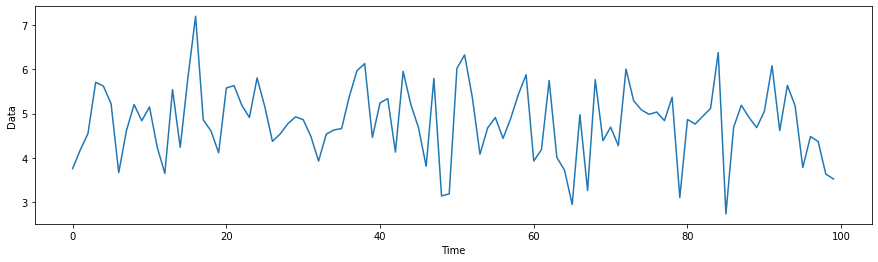

In [6]:
setFig()
plt.plot(y);

### ReLU

ReLU: Rectified linear unit adds a nonlinearlity to a neuron's activation.

In [7]:
# Compute and return ReLU of result (Hint: `torch.clamp`)
out = torch.clamp(y, 0., None)

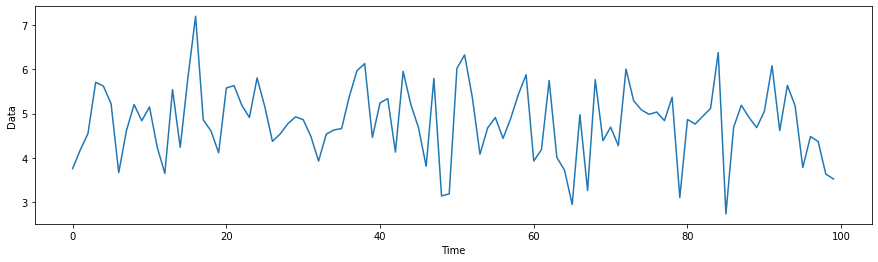

In [8]:
setFig()
plt.plot(out);

The output is as uncorrelated in time as the input!

### Feed forward networks

Several such (weights + ReLU) layers put together form the basis of what we we refer to as feed forward neural networks.

### Recurrent networks

When we want to introduce memory into a model, we use recurrent neural networks, that are a slight modification to feed forward models.

$\vec{y}(t) = \Theta(\vec{y}(t-1) + W.\vec{x} + b)$

<div>
    <img src="AN-neuron-rec.png" width=30%/>
</div>

In [9]:
# Define a forward method for a recurrent neuron model
def forward_rnn(x, W, b):
    time, n_input = x.shape
    y = []
    y_last = 0
    for t in range(time):
        # Update internal state
        v_mem = (x[t:t+1] @ W + b) + y_last
        # Compute the activation
        y_last = torch.clamp(v_mem, 0, None)
        # Record the activation
        y.append(y_last)
    return torch.concat(y)

In [10]:
y = forward_rnn(data_stream, W, -4)

In [11]:
y.shape

torch.Size([100, 1])

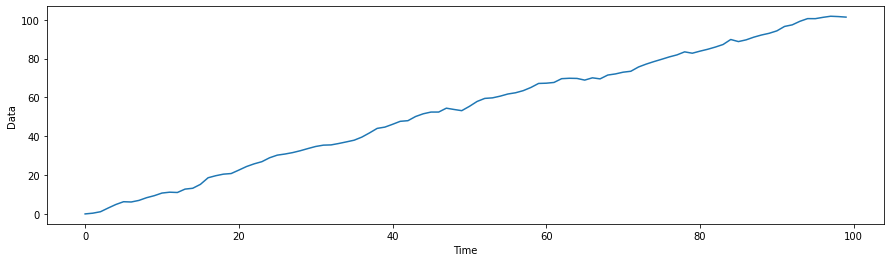

In [12]:
setFig()
plt.plot(y);

Here you see that the neuron's output integrates its inputs from the past. The information that it retains can be used to perform interesting computations, especially when a population of neurons interact in the case of RNNs.

## Spiking Neural Networks

Spiking neurons improve upon this notion of recurrent neurons by making the output binary and sparse.

They do so by replacing the activation function (ReLU) with a spike function.

If the internal state is above a threshold $\theta$, the neuron produces a binary event on the output. We'll use a Heaviside function for that.

$$y = H(v, \theta) = v > \theta$$

When a neuron sends an output, we reset $v$ by subtracting the threshold:

$$v = v - y * \theta$$

### Integrate and Fire Neuron

So putting all these things together, the dynamics of an Integrate and Fire Neuron can be defined as follows:

$$\vec{v}(t) = \vec{v}(t-1) + W.\vec{x} + b - \vec{y}\theta$$

$$y = H(v, \theta) = v > \theta$$


<div>
    <img src="iaf.png" width=30%/>
</div>

In [13]:
# Define a forward method for a spiking neuron model
def forward_snn(x, W, b, threshold=10.0):
    time, n_input = x.shape
    y = []
    v_mem = []
    v_mem_last = 0
    y_last = 0
    for t in range(time):
        # State update
        v_mem_last = (x[t:t+1] @ W + b) + v_mem_last - y_last*threshold
        # Activation
        y_last = (v_mem_last>threshold).float()
        # record output
        y.append(y_last)
        # record state
        v_mem.append(v_mem_last)
    return torch.concat(y), torch.concat(v_mem)

In [14]:
# Generate input spikes
spike_stream = (torch.rand((n_time_samples, n_input_channels))>0.9).float()

# Perform a forward pass
y, v_mem = forward_snn(spike_stream, W, b, threshold=25.0)

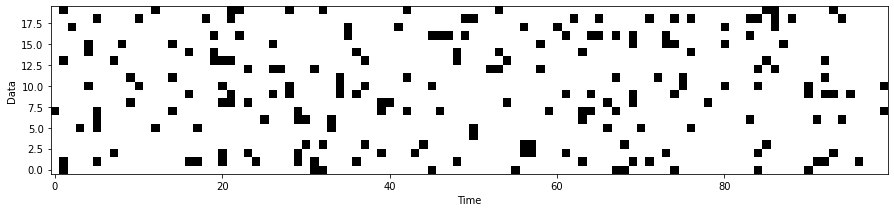

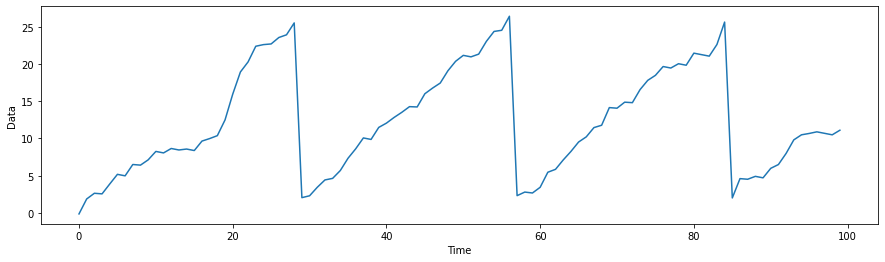

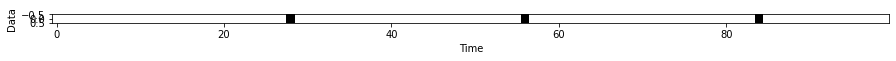

In [15]:
# Input and output visualization

# Plot input
setFig()
plt.imshow(spike_stream.T, origin="lower")

# Plot internal state
setFig()
plt.plot(v_mem)

# Plot output
setFig()
plt.imshow(y.T);

### Key take aways

1. Neurons hold **memory of past data**.
2. The input data is **binary**. This means computation is **much cheaper** than floating point operations in terms of **power**.
3. The input and output are **sparse**. This means you only need to perform a **fraction of the operations** needed for an fully connected RNN.

### Training strategies

We have seen how a spiking neuron works. How do you make them do interesting tasks?

In the sessions to follow, you will see how to get large number of spiking neurons to do interesting real-world tasks.
You will see how they work real-time on neuromorphic hardware.

Most importantly, you will do this all by yourself (with our help!).